In [56]:
import torch
from torchvision import datasets
import matplotlib.pyplot as plt
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

torch.manual_seed(123)

In [57]:
data_path = '../data-unversioned/p1ch7/'
cifar10 = datasets.CIFAR10(data_path, train=True, download=True)
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [58]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

In [59]:
type(cifar10).__mro__

(torchvision.datasets.cifar.CIFAR10,
 torchvision.datasets.vision.VisionDataset,
 torch.utils.data.dataset.Dataset,
 typing.Generic,
 object)

In [60]:
len(cifar10)

50000

In [61]:
img, label = cifar10[99]
img, label, class_names[label]

(<PIL.Image.Image image mode=RGB size=32x32>, 1, 'automobile')

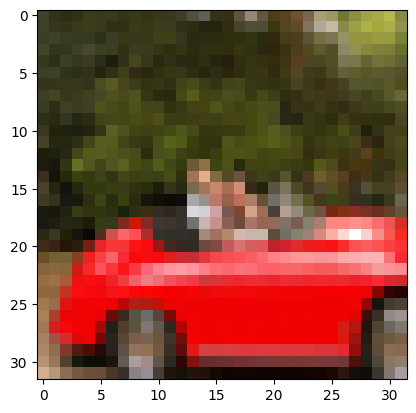

In [62]:
plt.imshow(img)
plt.show()

In [63]:
from torchvision import transforms
#Import all of the possible transforms, including the transform which converts the image to a tensor

In [64]:
to_tensor = transforms.ToTensor()
img_t = to_tensor(img)
img_t.shape #3 channels, 32x32 pixels

torch.Size([3, 32, 32])

In [65]:
tensor_cifar10 = datasets.CIFAR10(data_path, train=True, download=False, transform=transforms.ToTensor())

In [66]:
img_t, _ = tensor_cifar10[99]
type(img_t), img_t.min(), img_t.max()

(torch.Tensor, tensor(0.), tensor(1.))

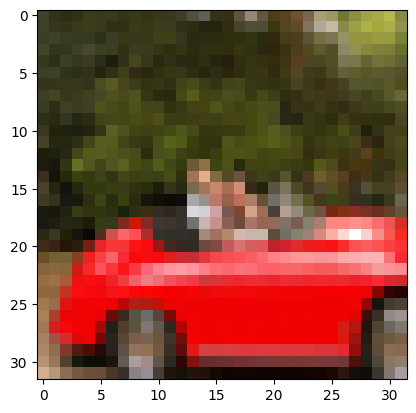

In [67]:
plt.imshow(img_t.permute(1, 2, 0)) #permute so that the colour channels are given by the final index
plt.show()

<p>Recall that, for functions such as the sigmoid, with nonzero gradients for arguments close to 0, it is in our interest to normalise our data so that it is centred at 1. This will increase the speed with which the network is trained on the data. We start by creating a stack in torch using all of the images in the dataset.</p>

In [68]:
imgs = torch.stack([img for img, _ in tensor_cifar10], dim = 3) #Stack along a new dimension
imgs.shape #3x32x32ximg_no

torch.Size([3, 32, 32, 50000])

In [69]:
#Calculate the mean values of the RGB channels
imgs.view(3, -1).mean(dim=1) #tells python that we want a 3*X tensor, where X will be found by python

tensor([0.4914, 0.4822, 0.4465])

In [70]:
#Calculate standard deviation
imgs.view(3,-1).std(dim=1)

tensor([0.2470, 0.2435, 0.2616])

In [71]:
transforms.Normalize(imgs.view(3,-1).mean(dim=1), imgs.view(3,-1).std(dim=1))

Normalize(mean=tensor([0.4914, 0.4822, 0.4465]), std=tensor([0.2470, 0.2435, 0.2616]))

In [72]:
#Apply transformation, where we now centre all of the colour channels on 0 with unit standard deviation
transformed_cifar10 = datasets.CIFAR10(
    root=data_path,
    train=True,
    download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(imgs.view(3,-1).mean(dim=1), imgs.view(3,-1).std(dim=1))])
    )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9802377..2.1267893].


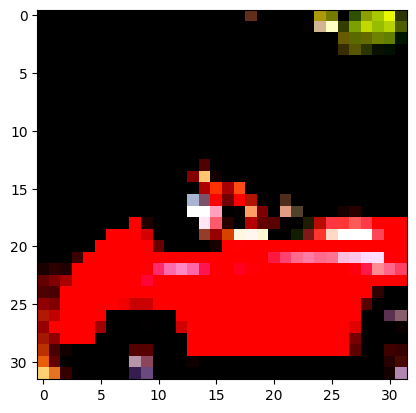

In [73]:
img_t, _ = transformed_cifar10[99]

plt.imshow(img_t.permute(1, 2, 0))
plt.show() #Note that all negative RGB values will just be clipped and shown as black

In [74]:
class_names #airplane has index 0, bird has index 2

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [75]:
label_map = {0:0, 2:1} #Maps airplane (index 0) to 0, and bird (index 2) to 1
class_names = ['airplane', 'bird']
#2 categories now- airplane and bird
cifar2 = [(img, label_map[label]) for img, label in transformed_cifar10 if label in [0,2]] #training set
cifar2_val = [(img, label_map[label]) for img, label in transformed_cifar10 if label in [0,2]] #validation set


# Building the Neural Network #
We know that each sample (i.e. each image) is going to have $3\times32\times32 =  3072$ inputs. So the first layer will be linear, with a first dimension of $3072$. We chose $512$ dimensions for our hidden layer, and our activation function will be tanh.


In [76]:
import torch.nn as nn

In [77]:
n_out = 2 #Number of output features- either a BIRD, or a PLANE
#Categorical data, so cannot output a single floating-point value on a scale of bird to plane, as the distinction is binary

#Constructing the neural network with the appropriate number of dimensions
model = nn.Sequential(
    nn.Linear(3072, 512), #Linear hidden layer taking the input data
    nn.Tanh(), #Hidden layer activation function
    nn.Linear(512, 2) #Output layer
)

# Softmax Function
The softmax function is given by: $$\frac{e^z}{\sum_i{e^z_i}}$$

It basically turns the entries of the tensor into a probability distribution (recall the partition function definition). In our case, we can interpret the use of the softmax function as the final activation function as giving us the possibilities that the picture is either of a bird or a plane. Given the output $[z_0, z_1]$ from the neural net, the final softmax activation function gives us:

$$
[\frac{e^{z_0}}{e^{z_0} + e^{z_1}}, \frac{e^{z_1}}{e^{z_0} + e^{z_1}}]
$$

so the first entry is the probability that it's a plane, and the second entry is the probability that it's a bird.

In [78]:
def softmax(x):
    return torch.exp(x) / torch.exp(x).sum()

In [79]:
x = torch.tensor([1., 2. , 3.])
softmax(x) #Performs the exponentiation on each of the elements and then divides by the sum of the exponentials

tensor([0.0900, 0.2447, 0.6652])

In [80]:
#Sanity check- the entries of the softmax tensor should sum to 1
softmax(x).sum()

tensor(1.)

In [81]:
softmax = nn.Softmax(dim=1)

x = torch.tensor([
    [1., 2., 3.],
    [1., 2., 3.]
])

softmax(x)

tensor([[0.0900, 0.2447, 0.6652],
        [0.0900, 0.2447, 0.6652]])

In [82]:
#Now, introducing the final softmax activation function
model = nn.Sequential(
    nn.Linear(3072, 512), #Linear hidden layer taking the input data
    nn.Tanh(), #Hidden layer activation function
    nn.Linear(512, 2), #Output layer
    nn.Softmax(dim=1) #Final activation function to help us distinguish between bird and plane
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8622148..2.0301533].


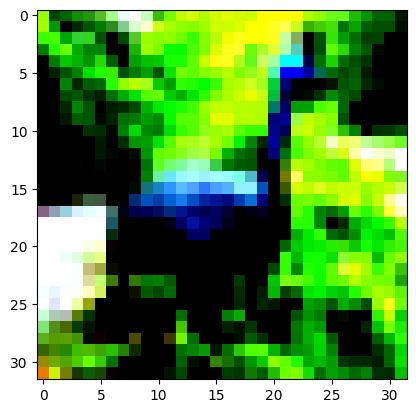

In [83]:
img, _ = cifar2[0]
plt.imshow(img.permute(1,2,0))
plt.show() #Looks like a bird.. lol

In [84]:
img_batch = img.view(-1).unsqueeze(0) #Take our 3x32x32 vector and make it 1D and then add a second dimension so that it fits the model
img_batch.shape #Need this to be 1x3072 to match the first hidden layer- can't just be 3017

torch.Size([1, 3072])

In [85]:
out = model(img_batch)
out #Model predicts it has a 57% chance of being a plane, and 43% chance of being a bird. But we haven't done any training (lololol)

tensor([[0.4784, 0.5216]], grad_fn=<SoftmaxBackward0>)

In [86]:
#does it say bird or airplane?
_, index = torch.max(out, dim=1) #maximum along dimension1 

index #guesses 0, i.e. thinks it's a plane :(

tensor([1])

Basically, softmax gives us two probabilities- <code>out[0]</code> gives us the probability of the image being a plane, and <code>out[1]</code> gives the probability of it being a bird.

We want a cost function that penalises incorrect guesses. We define the "likelihood"- that's the probability assigned by the network that the image is from the correct class. We want a large cost for low likelihood, and small cost for high likelihood.

For this we can use the <b>negative log likelihood</b>.

$$
f_{NNL}(\theta) = \sum_{i=1}^{N}{\text{log } p(y_i = t_i|x_i)}
$$

where we take the sum over N samples.

In [87]:
import numpy as np

/var/folders/j5/qqf885v16ps2h__10kf0m2th0000gn/T/ipykernel_14349/2486714267.py:2: RuntimeWarning: divide by zero encountered in log
  y = -np.log(x)


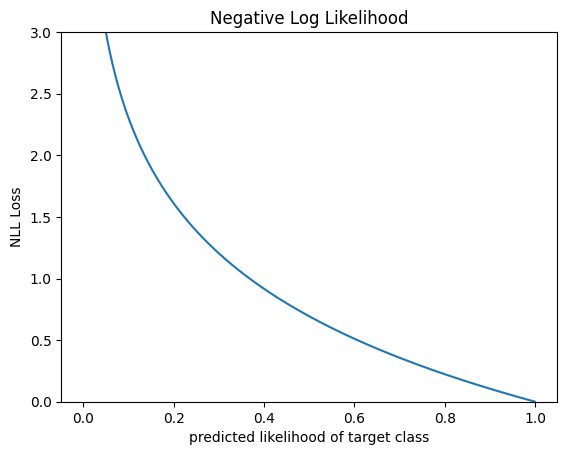

In [88]:
x = np.arange(0, 1, 0.001) #probabilities ranging from 0 to 1
y = -np.log(x)

plt.xlabel('predicted likelihood of target class')
plt.ylabel('NLL Loss')
plt.ylim(0,3)
plt.title('Negative Log Likelihood')
plt.plot(x, y)
plt.show()

In [89]:
#Update our neural network in order to make calculations numerically stable
model = nn.Sequential(
    nn.Linear(3072, 512), #Linear hidden layer taking the input data
    nn.Tanh(), #Hidden layer activation function
    nn.Linear(512, 2), #Output layer
    nn.LogSoftmax(dim=1) #Final activation function to help us distinguish between bird and plane
)

#Define NLL as our loss function
loss_fn = nn.NLLLoss()

In [90]:
img, label = cifar2[0] #The data is already labelled
out = model(img.view(-1).unsqueeze(0))
loss_fn(out, torch.tensor([label]))

tensor(0.5079, grad_fn=<NllLossBackward0>)

In [91]:
import torch.optim as optim

In [92]:
learning_rate = 1e-2
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

n_epochs = 100

# for epoch in range(n_epochs):
#     for img, label in cifar2:
#         out = model(img.view(-1).unsqueeze(0))
#         loss = loss_fn(out, torch.tensor([label]))

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
    
#     print(f'Epoch: {epoch+1}, Loss: {loss:.4f}')

## Data Loader ##

In Stochastic Gradient Descent (SDE), we randomly select subsamples of the data. This allows us to:
<ul>
<li>Save on computation time (we don't have to run over the whole dataset)</li>
<li>Prevent being trapped in local minima- this will also let us use a smaller learning rate</li>
<li>Slowly but surely converge on the global minimum (well, at least, in an ideal world)</li>
</ul>

In [93]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True) #64 batches of image tensors, each having dim 3x32x32

model = nn.Sequential(
    nn.Linear(3072, 512), #First hidden layer- takes pixel data 
    nn.Tanh(), #First activation function for the first hidden layer
    nn.Linear(512, 2), #Output layer
    nn.LogSoftmax(dim=1) #Output activation function- softmax basically generates a probability distribution, remember.
)

#Initialise parameters for training
learning_rate = 1e-2
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = nn.NLLLoss()
n_epochs = 100

In [94]:
for epoch in range(n_epochs):
    for imgs, labels in train_loader: 
        batch_size=imgs.shape[0] #Take first dimension 
        outputs = model(imgs.view(batch_size, -1))
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad() #Zero the gradients to prevent accumulation
        loss.backward()
        optimizer.step() #Perform optimization of parameters

    if (epoch+1) % 10 == 0 or (epoch+1) == 1:
        print(f"Epoch: {epoch+1}, Loss: {loss:.4f}")

Epoch: 1, Loss: 0.4084
Epoch: 10, Loss: 0.3078
Epoch: 20, Loss: 0.2268
Epoch: 30, Loss: 0.0975
Epoch: 40, Loss: 0.0522
Epoch: 50, Loss: 0.1774
Epoch: 60, Loss: 0.0733
Epoch: 70, Loss: 0.0556
Epoch: 80, Loss: 0.0352
Epoch: 90, Loss: 0.0402
Epoch: 100, Loss: 0.0099


In [95]:
#Now we have to perform tests using the validation set
import torch.utils.data.dataloader

val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=True) #64 images in the validation batch, make sure we are shuffling

correct = 0
total = 0

i=1

for imgs, labels in val_loader:
    
    batch_size = imgs.shape[0]
    outputs = model(imgs.view(batch_size, -1))
    _, predicted = torch.max(outputs, dim=1) #look for the maximum probability assigned
    total += labels.shape[0]
    
    if i == 1 or i % 50 == 0:
        print("Batch no:", i)
        print("Predicted labels: ", predicted)
        print("True labels: ", labels)
    
    for label, pred in zip(labels, predicted):
        if label == pred:
            correct += 1
    
    i+=1

accuracy = correct / total
print(f'Accuracy: {accuracy:.4f}')

Batch no: 1
Predicted labels:  tensor([0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0,
        1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0])
True labels:  tensor([0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0,
        1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0])
Batch no: 50
Predicted labels:  tensor([1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0,
        1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0,
        1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0])
True labels:  tensor([1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0,
        1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0,
        1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0])
Batch no: 100
Predicted labels:  tensor([

### What next? Increase the layer number!
So, we have some accuracy on the predictions of labels given by our model. We do this by using a data loader to sort through the validation set, 64 images at a time, and comparing the image labels predicted by our model (i.e. "bird" or "plane"), and then compare these predicted labels one-by-one to the true labels. Very obviously, we increase the number of "correct" predictions by 1 every time this guess is correct.

We can improve our model by giving it more time to "taper" between the input layer and the output- i.e., we can add more hidden layers.

### Cross Entropy Loss
We are currently using the <code>LogSoftMax</code> function as a final activation function, before passing to the <code>Negative Log Loss</code> loss function. We can wrap this whole process up into one step using <code>nn.CrossEntropyLoss</code>. To recap the two activation functions:

$$
\text{Softmax}(z_i) = \frac{e^{z_i}}{\sum_i{e^{z_i}}}
$$

$$
\text{LogSoftmax}(z_i) = \text{log }(\frac{e^{z_i}}{\sum_i{e^{z_i}}})
$$

where the clear interpretation of the output of Softmax's action on a tensor is to turn the tensor entries to values in a probability distribution.

Now, the loss function:

$$
f_{\text{NLL}}(\theta) = -\sum_i{\text{log }(\frac{e^{z_i}}{\sum_j{e^{z_j}}})}
$$

which recalls the Gibb's formula for entropy:

$$
S = -\sum_i{p_i \text{log } p_i}
$$

So, by using the <code>nn.CrossEntropyLoss</code> function, we no longer have to explicitly add in the final <code>LogSoftmax</code> function.

In [98]:
model = nn.Sequential(
    nn.Linear(3072, 1024),
    nn.Tanh(),
    nn.Linear(1024, 512),
    nn.Tanh(),
    nn.Linear(512, 128),
    nn.Tanh(),
    nn.Linear(128, 2)
)

#Use the cross-entropy loss function so that we don't need to bother with adding the softmax function to our network.
loss_fn = nn.CrossEntropyLoss()

In [105]:
#Seeing how many tunable parameters are inside of our model

numel_list = [p.numel() for p in model.parameters() if p.requires_grad == True] 
print('Number of parameters: ', sum(numel_list))
numel_list

Number of parameters:  3737474


[3145728, 1024, 524288, 512, 65536, 128, 256, 2]

### Translation invariance

A fully-connected linear network is NOT translation invariant- our model will only learn to recognise an object properly if its location in terms of pixels remains unchanged. Obviously this is far from ideal. This will lead to our model falling victim to <b>OVERFITTING</b>.

Ideally, we'd have some way of treating the image as it actually is- as 2D data. This is where Convolutional Neural Networks (CNNs) come into play.